Import librarys

In [1]:
import ee
import geemap as gmp
import geopandas as gpd
from ipygee import *
import pandas as pd


In [2]:
ee.Initialize()

Set directory ## this is for clarity and better manipulation of folders for me.

In [3]:
import os,glob
g = os.getcwd()
g
path = 'D:\\repos\\CIAT\\MAFF'
os.chdir(path)

Read files from GEE user

stack image and add VIs in time series

In [4]:
#function Cloud mask
def clouds_shadows_mask_S2(image):
    shadows_mask = image.select('SCL').eq(3).Not() # Shadow-free pixels
    clouds_mask = image.select('SCL').lt(7).Or(image.select('SCL').gt(9)) # Cloud-free pixels
    empirical_clouds_mask = image.select('B2').lte(1500) # Cloud-free pixels
    clouds_mask = clouds_mask.And(empirical_clouds_mask) # Cloud-free pixels
    mask = shadows_mask.And(clouds_mask) # Cloud-shadow-free pixels
    
    return image.updateMask(mask)#.copyProperties(image,["system:time_start"])
#function reflectance
def reflectance(image):
    return ee.Image(image.multiply(0.0001).copyProperties(image,["system:time_start"]))

def addKNDVI(image):
    # // Compute D2 a rename it to d2
    D2 = image.select('B8').subtract(image.select('B4')).pow(2).select([0],['d2'])
    # // Gamma, defined as 1/sigmaˆ2
    gamma = ee.Number(4e6).multiply(-2.0);
    # // Compute kernel (k) and KNDVI
    k = D2.divide(gamma).exp()
    kndvi = ee.Image.constant(1).subtract(k).divide(ee.Image.constant(1).add(k)).select([0],['KNDVI'])
    return image.addBands(kndvi)

def addKNDRE(image):
    # // Compute D2 a rename it to d2
    D2 = image.select('B8').subtract(image.select('B5')).pow(2).select([0],['d2'])
    # // Gamma, defined as 1/sigmaˆ2
    gamma = ee.Number(4e6).multiply(-2.0);
    # // Compute kernel (k) and KNDVI
    k = D2.divide(gamma).exp()
    kndvi = ee.Image.constant(1).subtract(k).divide(ee.Image.constant(1).add(k)).select([0],['KNDRE'])
    return image.addBands(kndvi)

#Function to calculate and add an VIs band
def VIs_S2(image):
    IVs = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    IVs = IVs.addBands(image.normalizedDifference(['B8', 'B5']).rename('NDRE'))
    IVs = IVs.addBands(image.normalizedDifference(['B8', 'B3']).rename('GNDVI'))
    IVs = (IVs.addBands(image.expression(
    '(NIR - RE) / (NIR + RED )',{
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'RE': image.select('B5')}).rename('NDRED')))
#     IVs = (IVs.addBands(image.expression(
#     '(NIR - 2 * RED + BLUE)/(NIR + 2 * RED - BLUE)', {
#       'NIR': image.select('B8'),
#       'RED': image.select('B4'),
#       'BLUE': image.select('B2')}).rename('ARVI')))
#     IVs =( IVs.addBands(image.expression(
#     'NIR/(NIR + RED)', {
#       'NIR': image.select('B8'),
#       'RED': image.select('B4'),}).rename('IPVI')))
#     IVs = (IVs.addBands(image.expression(
#     '(NIR-RED)/(NIR+RED + 0.16)', {
#       'NIR': image.select('B8'),
#       'RED': image.select('B4'),}).rename('OSAVI')))
#     IVs = (IVs.addBands(image.expression(
#     'GREEN - 0.39 * RED - 0.69 * BLUE', {
#       'BLUE': image.select('B2'),
#       'RED': image.select('B4'),
#       'GREEN': image.select('B3'),}).rename('TGI')))
    return IVs

In [7]:
# search images Sentinel 2 since January 2019 to Agust 2020 in the Region Of Interes (ROI have convexhull)
def FT_Satellite(sensor,ROI,data_ini = '2020-07-29',data_end = '2021-04-16',cloud_mask = True, VI=True, KVI=True):
    '''
    sensor is the satellite image to select:
    S2_SR = SENTINEL 2 REFLECTANCE
    S1_GRD = SENTINEL 1 RADAR
    
    return Dataframe with Bands and VIs by each plot
    '''
    ROI = gmp.geopandas_to_ee(ROI)
    if sensor=="S2_SR":
        S2 = (ee.ImageCollection('COPERNICUS/'+sensor)
                .filterDate(data_ini,data_end)
                .filterBounds(ROI))# filter according to drawn boundary
        # # // Add maskcloud band to image collection
        if cloud_mask:
            S2 = S2.map(clouds_shadows_mask)
        if VI:
            S2 = S2.map(VIs)
            VIs = S2.select(["B2","B3","B4","B5","B8","NDVI",'GNDVI','NDRED',"NDRE"])
        if KVI:
            S2 = S2.map(addKNDVI)
            S2 = S2.map(addKNDRE)
            # Select the bands
            VIs = S2.select(["B2","B3","B4","B5","B8","NDVI","KNDVI",'GNDVI','NDRED',"NDRE",'KNDRE'])

    # Empty Collection to fill
    ft_empty = ee.FeatureCollection(ee.List([]))
    #Function to extract means values from each Plot inside of ROI with his date 
    def fill_ft(img, ini):
    #   type cast
        inift = ee.FeatureCollection(ini)
    #   gets the values(Mean,max,median,min,stdDev) for the points in the current img
        img_reduce_mean = img.reduceRegions(ROI, ee.Reducer.first(),10)
        img_reduce_min = img.reduceRegions(ROI, ee.Reducer.min(),10)
        img_reduce_max = img.reduceRegions(ROI, ee.Reducer.max(),10)
        img_reduce_median = img.reduceRegions(ROI, ee.Reducer.median(),10)
        img_reduce_SD = img.reduceRegions(ROI, ee.Reducer.stdDev(),10)
        #   gets the date of the img
        date = img.date().format()
        #   add date from image
        def add_date(dates):
            return dates.set("date", date)
    #   writes the date in each feature
        img_reduce_mean = img_reduce_mean.map(add_date)
    #   merges the FeatureCollections
        ft1 = img_reduce_mean.merge(img_reduce_min)
        ft2 = ft1.merge(img_reduce_max)
        ft3 = ft2.merge(img_reduce_median)
        ft4 = ft3.merge(img_reduce_SD)
        return inift.merge(ft4)
    # Iterates over the ImageCollection
    newft = ee.FeatureCollection(VIs.iterate(fill_ft, ft_empty,ROI))
    # Convery FeatureCollection to Pandas(DataFrame)
    gdf1 = gmp.ee_to_pandas(newft) 
    return(gdf1)

In [8]:
canada = gpd.read_file('data/canada/SHP/PLOTS.shp')
campinas = gpd.read_file('data/campinas/SHP/lotes/PLOTS4326.shp')

# data/canada/SHP/PLOTS.shp - data/campinas/SHP/lotes/PLOTS4326.shp

In [9]:
sensor = 'S2_SR'
'COPERNICUS/S2_SR'+ sensor

'COPERNICUS/S2_SR'

select VIs and extrac features in time series for each id from ROI in feature collection

In [30]:
CAMPINAS = FT_Satellite('S2_SR',campinas,data_ini = '2020-07-29',data_end = '2020-07-31',cloud_mask = True, VI=True, KVI=True)
# CANADA = FT_Satellite('S2_SR',canada,data_ini = '2020-07-29',data_end = '2021-04-16',cloud_mask = True, VI=True, KVI=True)

TypeError: iterate() takes from 2 to 3 positional arguments but 4 were given

covert featurecollection in a Data Frame (pandas)

In [15]:
# gdf = eeconvert.fcToGdf(newft,crs={'init': 'epsg:4326'}) #feature collection from Geopandas
CAMPINAS.head()
# print(np.unique(CAMPINAS.date))
# gdf1 = CAMPINAS.copy()
# gdf = gdf.dropna() #delete NaN

# del gdf['geometry'] #delete geometry column
# del gdf["ID"] #delete geometry ID

NameError: name 'CAMPINAS' is not defined

In [40]:
gdf1.dropna(inplace=True)
gdf1.head()
# gdf1["date"] = gdf1["date"].str.split("T", n = 1, expand = True)
# gdf1['date'] = pd.to_datetime(gdf1['date'], format='%Y-%m-%d').dt.date
# gdf1
# gdf1.to_csv('data/Campinas/FT/S2.csv',index=False)

# len(np.unique(gdf1.names))
# np.unique(gdf1.date)

,B2,B3,B4,B5,B8,GNDVI,ID,KNDRE,KNDVI,NDRE,NDRED,NDVI,date,names
0,763.0,1074.0,1092.0,1657.0,3186.0,0.495775,1,0.145084,0.267391,0.315713,0.357410,0.489481,2020-07-30,G 01
1,836.0,1180.0,1242.0,1646.0,3544.0,0.500423,2,0.221421,0.319599,0.365703,0.396573,0.480986,2020-07-30,G 02
2,356.0,598.0,595.0,1347.0,3076.0,0.674469,3,0.184696,0.366791,0.390911,0.470989,0.675838,2020-07-30,G 03
3,471.0,960.0,789.0,1446.0,3824.0,0.598662,4,0.339414,0.519534,0.451233,0.515500,0.657923,2020-07-30,G 04
4,617.0,1050.0,834.0,1475.0,3916.0,0.577124,5,0.356094,0.532530,0.452792,0.513895,0.648842,2020-07-30,G 05


Use Melt for better organization from seaborn

Comvert column Date in format Date

In [38]:
# df_copy["date"] = df_copy["date"].str.split("T", n = 1, expand = True)
# df_copy['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.date
# df_copy

In [ ]:
## filter DF

Settup Plot

In [15]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook
import seaborn as sns
# sns.set_style("white")
rc={"font.weight":"bold",'figure.figsize':(20, 10),'axes.labelsize': 28, 
    'font.size': 28,'axes.titlesize': 28,'legend.fontsize': 18, 'axes.titlesize': 28,
   "lines.linewidth": 2.5,'font.sans-serif': "Times New Roman"}
# sns.set()
sns.set(style="white", rc=rc,font_scale = 1.8)
# sns.set_style("white")
# sns.set_context("paper",rc=rc,font_scale = 1.5)
DATE = pd.DataFrame({
    'inside':[
        '2020-03-14','2020-05-02','2020-06-21','2020-08-03'],
    'outside':[
        '2020-03-19','2020-05-07','2020-06-27','2020-08-08']
})

DATE['inside'] = pd.to_datetime(DATE['inside'], format='%Y-%m-%d')
DATE['outside'] = pd.to_datetime(DATE['outside'], format='%Y-%m-%d')

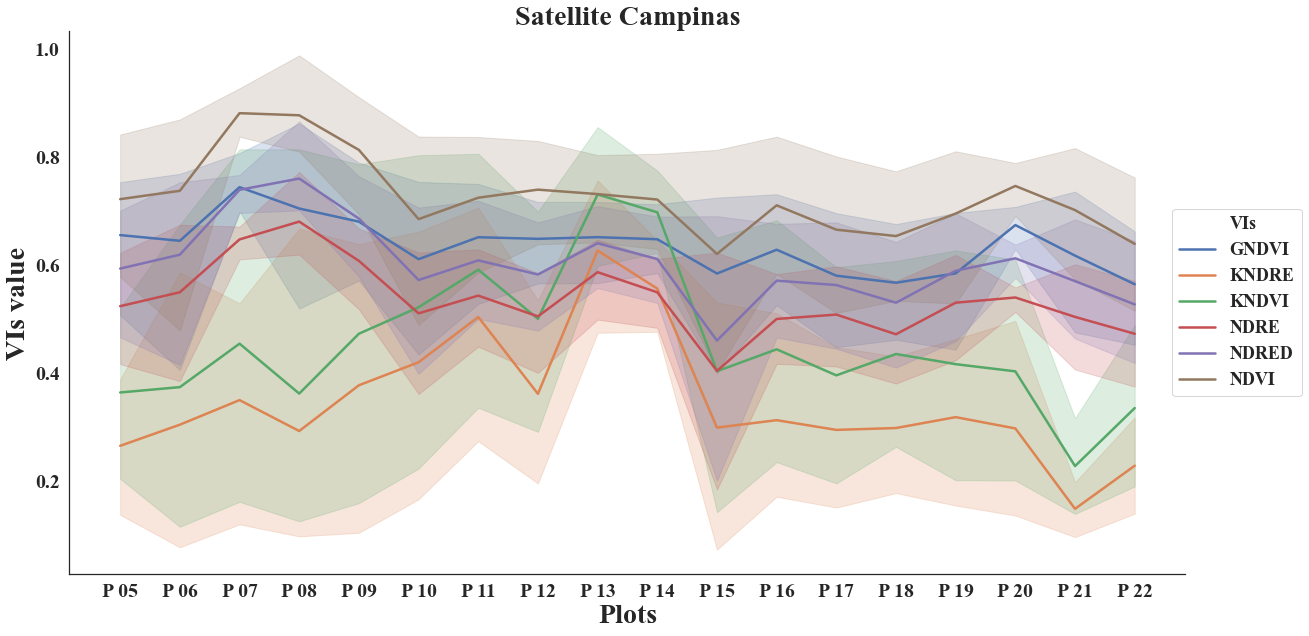

In [16]:
p = sns.lineplot('names', 'VIs_value', hue='VIs',
             data=df_copy)
# p.pointplot('plots_C', 'NDVI', data=df1)
p.set(xlabel='Plots', ylabel='VIs value',title="Satellite Campinas")
# for inside  in DATE.inside:
#     p.axvline(inside,color='r',label="Cows come in")
# for outside in DATE.outside:
#     p.axvline(outside,color='g',label="Cows come out")
    
handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1)
sns.despine()
figure = p.get_figure()
# figure.savefig('Img/campinas/NDVI-12M20-1.png', dpi=600)

Plots Time series  from a ID

In [ ]:
df1 = pd.read_csv('data/campinas/FT/TS_NDVI.csv')

df1['date'] = pd.to_datetime(df1['date'], format='%m/%d/%Y')
df1=df1[df1['date']=='2020-03-12']

df1["plots_C"] = pd.Categorical(df1['PLOTS'], categories=['plot 1','plot 2','plot 3','plot 4','plot 5','plot 6',
                                         'plot 7','plot 8','plot 9','plot 10','plot Q8','plot Q7','plot Q6'], ordered=False)

df1["plots_C1"] = pd.Categorical(['plot 1','plot 2','plot 3','plot 4','plot 5','plot 6',
                                         'plot 7','plot 8','plot 9','plot 10','plot C5','plot C6','plot C7'],
                                 categories=['plot 1','plot 2','plot 3','plot 4','plot 5','plot 6',
                                         'plot 7','plot 8','plot 9','plot 10','plot C7','plot C6','plot C5'], ordered=False)

In [ ]:
p = sns.lineplot('plots_C', 'NDVI',ci=None, marker='o',
             data=df_copy)
# p.pointplot('plots_C', 'NDVI', data=df1)
p.set(xlabel='Plots', ylabel='VIs value',title="Satellite NDVI Campinas")
# for inside  in DATE.inside:
#     p.axvline(inside,color='r',label="Cows come in")
# for outside in DATE.outside:
#     p.axvline(outside,color='g',label="Cows come out")
    
handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1)
sns.despine()
figure = p.get_figure()
figure.savefig('Img/campinas/NDVI-12M20-1.png', dpi=600)